In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
import math
from datetime import date
import datetime
from functools import reduce
import warnings
import random
import re
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
warnings.filterwarnings("ignore")

In [2]:
personal_data = pd.read_csv('./data/personal_train.csv')
personal_data = personal_data.drop(['Unnamed: 0'],axis=1)
other_data = pd.read_csv('./data/other_train.csv')
other_data = other_data.drop(['Unnamed: 0'],axis=1)

Zlúčenie dvoch datasetov do jedného, na základe stĺpcov, alebo stĺpca (v parametroch)

In [3]:
class MergeTransformer(TransformerMixin):
    def __init__(self,df1,df2,cols):
        self.df1 = df1
        self.df2 = df2
        self.cols = cols
    
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df = pd.merge(self.df1,self.df2,on=self.cols)
        return df

Najprv sa uložia všetky duplikáty z DF, v pôvodnom sa vymažú, a následne sa vytvorí 1 unikátny záznam z množiny duplikátov, ktorý sa uloží na pôvodný dataset. Ak má stĺpec: spojité hodnoty, tak sa vyráta priemer. Ak má diskrétne, tak sa priradí náhodne, ak má samé NaN alebo ?, tak NaN.

In [4]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self,cols,groupBy):
        self.cols = cols
        self.groupBy = groupBy
    
    def _checkNaN(self,arr):
        for item in arr:
            if((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item)):
                return False
        return True
    def _checkQuestionMark(self,arr):
        for item in arr:
            if(item is not '?'):
                return False
        return True
    def _nanOrQuestionMark(self,arr):
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                return False
        return True
    
    def _filter_nan_question_mark(self,arr):
        result = []
        for item in arr:
            if(item is not '?' and ((type(item) is not np.float64 and type(item) is not float) or not np.isnan(item))):
                result.append(item)
        return result 
    
    def _getUniqueRow(self,duplicates,startIndex,endIndex):
        row_dict = {}

        for column in duplicates.columns: 
            temp = []
            for index in range(startIndex,endIndex):
                temp.append(duplicates.iloc[index][column])
         
            if(self._checkNaN(temp)):
                row_dict[column] = np.nan
            elif(self._checkQuestionMark(temp)):
                row_dict[column] = np.nan
            elif(self._nanOrQuestionMark(temp)):
                row_dict[column] = np.nan
            else:
                temp = self._filter_nan_question_mark(temp)
                if(np.array(temp).dtype == 'float64'):
                    row_dict[column] = np.mean(temp)
                else:
                    value = randint(0,len(temp)-1)
                    row_dict[column] = temp[value]
        return row_dict

    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        duplicated = df.duplicated(subset=self.cols,keep=False)
        duplicates = pd.DataFrame(columns=df.columns)
        indexes_to_drop = []
        df_without_duplicates = pd.DataFrame(columns=df.columns)
        for index, row in df.iterrows():
            if(duplicated[index]):
                duplicates = duplicates.append(df.iloc[index],ignore_index=True)
                indexes_to_drop.append(index)

        duplicates.sort_values(self.cols)
        df_without_duplicates = df
        for index in indexes_to_drop:
            df_without_duplicates = df_without_duplicates.drop(df.index[index])

        df = df_without_duplicates
        count = 0
        lastDuplicate = duplicates.iloc[0][self.groupBy]
        columns = duplicates.columns.values
        for index,row in duplicates.iterrows():
            entry = duplicates.iloc[index]
            name = entry[self.groupBy]
            if(name == lastDuplicate):
                count += 1
            else:
                df = df.append(self._getUniqueRow(duplicates,index-count,index),ignore_index=True)
                lastDuplicate = name
                count = 1
        
            if(len(duplicates) - 1 == index):
                df = df.append(self._getUniqueRow(duplicates,index-count+1,index + 1),ignore_index=True)
        
        return df

Zadáme nežiaduce znaky ako parametre, a následne preiterujeme všetky údaje, a pokiaľ narazíme na daný nežiaduci znak, tak mu priradíme NaN.

In [5]:
class ToNaNTransformer(TransformerMixin):
    def __init__(self,signs):
        self.signs = signs
    
    def _checkSign(self,x):
        for sign in self.signs:
            if sign == str(x).strip(" "):
                return True
        return False
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in df.columns:
            df[column] = df[column].map(lambda x: np.nan if self._checkSign(x) else x)
        return df

Pokiaľ máme stĺpec, ktorý obsahuje objekty, tak ho rozložíme na viacero stĺpcov. Pôvodný stĺpec nevymazávame, pretože ho možno ešte budeme potrebovať.

In [6]:
class ObjectValuesTransformer(TransformerMixin):
    def __init__(self,columns):
        self.cols = columns
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index, row in df.iterrows():
            for column in self.cols:
                if(str(row[column]) != 'nan'):
                    newRow = eval(str(row[column]))
                    for key, value in newRow.items():
                        df.loc[index,key] = value
        return df

Na zvolených stĺpcoch vyráta priemernú hodnotu, a doplní do NaN hodnôt.

In [7]:
class MeanTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.col_means = {}
        
    def fit(self,df, y=None):
        
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.col_means[column] = math.floor(np.nanmean(df[column].tolist()))
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.col_means[column] if str(x).lower() == 'nan' else float(x))
        return df


Sformátovanie rôznych formátov dátumov na jednotný formát.

In [8]:
class FormatDateTransformer(TransformerMixin):
    def __init__(self,column):
        self.column = column
    def _format_date(self,string):
        for fmt in ["%Y/%m/%d", "%Y%m%d", "%y-%m-%d", "%Y-%m-%d", "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H %M %S", "%d/%m/%Y"]:
            try:
                return datetime.datetime.strptime(string, fmt).date()
            except ValueError:
                continue
        raise ValueError(string)
        
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        df[self.column] = df[self.column].map(lambda x: self._format_date(x) if type(x) is str else x)
        return df
    

Táto funkcia vyráta priemerný dátum pre NaN hodnotu, spomedzi všetkých dátumov.

In [9]:
class MeanDateTransformer(TransformerMixin):
    def __init__(self,age_column,date_column):
        self.age_column = age_column
        self.date_column = date_column
        self.mean_age = 0;
        self.mean_date = 0;
        
    def fit(self,df,y=None):
        self.mean_age = np.nanmean(df[self.age_column].tolist())
        self.mean_date = datetime.datetime(math.floor(datetime.datetime.now().year - self.mean_age), datetime.datetime.now().month, datetime.datetime.now().day,
                           datetime.datetime.now().hour, datetime.datetime.now().minute).date()
        return self
    def transform(self,df,y=None):
        df[self.date_column] = df[self.date_column].map(lambda x: self.mean_date if str(x) == 'nan' else x)
        i = 0
        for date in df[self.date_column]:
            if(date > datetime.datetime.now().date()):
                modifiedDate = datetime.datetime(datetime.datetime.now().year-int(df[self.age_column][i]), date.month, date.day).date()
                df[self.date_column][i] = modifiedDate 
            i += 1
        return df

Pre daný stĺpec, ktorý ma obsahovať len T a F hodnoty (no obsahuje aj nežiaduce hodnoty ako False,FALSE,F.15) urobíme algoritmus, ktorý zjednotí všetky hodnoty len na prislúchajúce T a F.

In [10]:
class TrueFalseTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def _mapTrueFalse(self,x):
        if("t" in str(x).lower()):
            return "t"
        elif("f" in str(x).lower()):
            return "f"
        else:
            return np.nan
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self._mapTrueFalse(x))
        return df

Algoritmus vyráta pre stĺpec medián, a doplní ho do NaN riadkov.

In [11]:
class MedianTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_median = {}
        
    def fit(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
            self.cols_median[column] = np.nanmedian(df[column].tolist())
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: self.cols_median[column] if str(x).lower() == 'nan' else x)
        return df

Táto funkcia doplní do NaN riadkov určitú hodnotu. Táto hodnota sa vyráta nasledovne: Zistíme pomer všetkých hodnôt, a náhodne sa na základe toho vyberie hodnota, ktorá sa vloží do NaN riadku

In [12]:
class CategoricalTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.cols_value_to_fill = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.cols_value_to_fill[column] = pd.Series(np.random.choice(self._getUniqueValues(df[column]),p=self._getRatio(df[column]),size=len(df[column])))
        return self
    
    def _getUniqueValues(self,arr):
        return arr.value_counts(normalize=True, dropna=True).index

    def _getRatio(self,arr):
        return arr.value_counts(normalize=True, dropna=True).values
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].fillna(self.cols_value_to_fill[column])
        return df

Ako parametrom je pole objektov, ktorý sa zkladá z: 1.stĺpec, 2. znak z ktorého chceme meniť, 3.znak na ktorý chceme meniť. Čiže v určitom stĺpci zmeníme jeden znak na druhý. Taktiež v tejto funkcií dáme všetky znaky na malé písmená.

In [13]:
class ReplacerTransformer(TransformerMixin):
    def __init__(self,replace_info_arr):
        self.all_info = []
        for replace_info in replace_info_arr:
            self.all_info.append(replace_info)
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for info in self.all_info:
            df[info["column"]] = df[info["column"]].map(lambda x: str(x).lower().replace(info["current"],info["new"]))
        return df

Do NaN hodnôt sa dosadí hodnota. Táto hodnota je vyrátaná ako: Zoberieme S

In [14]:
class KnearestTransformer(TransformerMixin):
    def __init__(self,columns,k=3):
        self.columns = columns
        self.k_num = k
    
    def _kNearest(self,df,column,k=3):
        kNearest = []
        i = 0
        for item in df[column]:
            if(str(item) == 'nan'):
                kNearest = []
                for index in range(2*k+1):
                    if(i+k-index < len(df) and i+k-index > -1 and i+k-index != i and str(df[column][i+k-index]) != 'nan'):
                        kNearest.append(df[column][i+k-index])
                nearestAvg = reduce(lambda x, y: x + y, kNearest) / len(kNearest)
                df[column][i] = math.floor(nearestAvg)
            i += 1
        return df
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for column in self.columns:
               df = self._kNearest(df,column,self.k_num)
        return df

Age je špecifický stĺpec, pre ktorý odstraňujeme vychýlené hodnoty. Keďže veku prislúcha aj dátum, tak pri hodnotách, ktoré zmeníme pri Age stĺpci, tak ich zmeníme aj pri dátume (tak, aby dátum narodenia sedel s vekom).

In [15]:
class OutleirsRemovalForAgeAndDateTransformer(TransformerMixin):
    
    def __init__(self,age_column,date_column,value):
        self.age_column = age_column
        self.date_column = date_column
        self.value = value
    def fit(self,df,y=None):
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            if(df[self.age_column][index] > self.value):
                df[self.age_column][index] = self.value
                df[self.date_column] = datetime.datetime(math.floor(datetime.datetime.now().year - self.value), df[self.date_column][index].month, df[self.date_column][index].day).date()
                
        return df

Na všetkych stĺpcoch, o ktorých predpokladáme, že majú byť číselné, vykonáme túto funkciu, ktorá z nich urobí floaty (aj keď predtým boli stringy, alebo objekty). 

In [16]:
class FormatToFloatTransformer(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        for column in self.columns:
            df[column] = df[column].map(lambda x: float(x))
        return df

Nahradenie vychýlené hodnoty z float stĺpca. Výchýlená hodnota je hodnota menšia ako 5 percentil alebo väčšia ako 95 percentil. Pokiaľ je číslo menšie ako 5 percentil, nahradíme ju číslom, ktoré je rovné 5 percentilu, a ak je väčšie ako 95 percentil, nahradíme ju číslom, ktoré reprezentuje 95 percentil.

In [17]:
class OutleirsRemoval(TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
        self.outlayer_95 = {}
        self.outlayer_5 = {}
    def fit(self,df,y=None):
        for column in self.columns:
            self.outlayer_95[column] = np.nanpercentile(df[column],95)
            self.outlayer_5[column] = np.nanpercentile(df[column],5)
        return self
    def transform(self,df,y=None):
        for index,row in df.iterrows():
            for column in self.columns:
                if df[column][index] > self.outlayer_95[column]:
                    df[column][index] = self.outlayer_95[column]
                elif df[column][index] < self.outlayer_5[column]:
                    df[column][index] = self.outlayer_5[column]
        return df
            

In [18]:
true_false_columns = ["sick","T3 measured","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TBG measured","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "T4U measured", "tumor",
                    "goitre","hypopituitary","on antithyroid medication"]

categorical_columns = ["sick","query hypothyroid", "query hyperthyroid","FTI measured","lithium","TT4 measured", "pregnant",
                     "thyroid surgery","TSH measured","query on thyroxine","I131 treatment","on thyroxine","psych", "tumor",
                     "goitre","hypopituitary","on antithyroid medication","sex","workclass","native-country","occupation","T3 measured","T4U measured"]

replace_info = [
    {
        "column":"education",
        "current":"_",
        "new":"-"
    },
    {
        "column":"class",
        "current": ".|",
        "new":"|"
    }
]

pip_merge = Pipeline([
    ('merge',MergeTransformer(personal_data,other_data,["name","address"]))
])
pip = Pipeline([
    ('objectvalues',ObjectValuesTransformer(["medical_info"])),
    ('deduplicate',DeduplicationTransformer(["name","address"],"name")),
    ('nan',ToNaNTransformer(["?","nan","?.4"])),
    ('format-date',FormatDateTransformer("date_of_birth")),
    ('format-to-floats',FormatToFloatTransformer(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('date-outlayers',OutleirsRemovalForAgeAndDateTransformer("age","date_of_birth",110)),
    ('outlayers',OutleirsRemoval(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('mean',MeanTransformer(["age","T4U","capital-loss","TSH","FTI","fnlwgt","hours-per-week"])),
    ('median',MedianTransformer(["T3","education-num"])),
    ('knearest',KnearestTransformer(["TT4"])),
    ('date',MeanDateTransformer("age","date_of_birth")),
    ('true-false-mapping',TrueFalseTransformer(true_false_columns)),
    ('categorical',CategoricalTransformer(categorical_columns)),
    ('replacer',ReplacerTransformer(replace_info))
])
merged_before_transform = pd.DataFrame()
model = pip_merge.fit(merged_before_transform)
merged_before_transform = model.transform(merged_before_transform)
model = pip.fit(merged_before_transform)
merged = model.transform(merged_before_transform)

Mergnutie validneho datasetu

In [19]:
personal_data_valid = pd.read_csv('./data/personal_valid.csv')
personal_data_valid = personal_data_valid.drop(['Unnamed: 0'],axis=1)
other_data_valid = pd.read_csv('./data/other_valid.csv')
other_data_valid = other_data_valid.drop(['Unnamed: 0'],axis=1)

pip_merge_valid = Pipeline([
     ('merge',MergeTransformer(personal_data_valid,other_data_valid,["name","address"]))
]) 
merged_valid_before_transform = pd.DataFrame()
model_valid = pip_merge_valid.fit(merged_valid_before_transform)
merged_valid_before_transform = model_valid.transform(merged_valid_before_transform)

Spustenie predspracovanie z druheho zadania na vyssie mergnuty dataset

In [20]:
merged_valid = model.transform(merged_valid_before_transform)


Pipeline pre druhu variantu doplnania v druho odovzdani sme vacsinu float stlpcov doplnali priemerom preto sa pokusime v tejto pipeline doplnat viac stlpcov medianom

In [21]:

pip_merge2 = Pipeline([
    ('merge',MergeTransformer(personal_data,other_data,["name","address"]))
])
pip2 = Pipeline([
    ('objectvalues',ObjectValuesTransformer(["medical_info"])),
    ('deduplicate',DeduplicationTransformer(["name","address"],"name")),
    ('nan',ToNaNTransformer(["?","nan","?.4"])),
    ('format-date',FormatDateTransformer("date_of_birth")),
    ('format-to-floats',FormatToFloatTransformer(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('date-outlayers',OutleirsRemovalForAgeAndDateTransformer("age","date_of_birth",110)),
    ('outlayers',OutleirsRemoval(["age","T4U","capital-loss","capital-gain","TSH","FTI","T3","education-num","TT4","hours-per-week","fnlwgt"])),
    ('median',MedianTransformer(["age","T4U","capital-loss","TSH","FTI","fnlwgt","hours-per-week"])),
    ('mean',MeanTransformer(["T3","education-num"])),
    ('knearest',KnearestTransformer(["TT4"])),
    ('date',MeanDateTransformer("age","date_of_birth")),
    ('true-false-mapping',TrueFalseTransformer(true_false_columns)),
    ('categorical',CategoricalTransformer(categorical_columns)),
    ('replacer',ReplacerTransformer(replace_info))
])
merged2_before_transform = pd.DataFrame()
model2 = pip_merge2.fit(merged2_before_transform)
merged2_before_transform = model2.transform(merged2_before_transform)
model2 = pip2.fit(merged2_before_transform)
merged2 = model2.transform(merged2_before_transform)


TBG stlpec dame vsetko na null kedze tam mame len NaN

In [22]:
merged["TBG"] = 0
merged2["TBG"] = 0
merged_valid["TBG"] = 0

Dropneme medical info pre vsetky datasety kedze sme ho v predspracovani uz rozdelili je nam nepotrebný

In [23]:
merged = merged.drop(['medical_info'],axis=1)
merged2 = merged2.drop(["medical_info"],axis=1)
merged_valid = merged_valid.drop(['medical_info'],axis=1)

In [24]:
def splitCols(df,column,splitter, columns):
    split = pd.DataFrame(df[column].str.split("|",2).tolist(),columns = columns)
    df = df.drop([column],axis=1)
    return pd.concat([df,split],axis=1,sort=False)

def encoding(df,columns):
    dummies = pd.concat([pd.get_dummies(df[column],prefix=column) for column in columns],axis=1,sort=False)
    df = df.drop(columns,axis=1)
    return pd.concat([df, dummies], axis=1,sort=False)



Encodneme jednotlive kategoricke stlpce a nasledne samostatne encodneme stlpec class kedze chceme len jeden stlpec kde negative je 0 increased 1 a decreased 2

In [25]:

merged = splitCols(merged,"class",'|',["class","class_value"])
merged = encoding(merged,categorical_columns)

merged2 = splitCols(merged2,"class",'|',["class","class_value"])
merged2 = encoding(merged2,categorical_columns)

merged_valid = splitCols(merged_valid,"class",'|',["class","class_value"])
merged_valid = encoding(merged_valid,categorical_columns)

In [26]:
def classEncoder(x):
    if(x == 'negative'):
        return 0
    elif (x =='increased binding protein'):
        return 1
    elif (x == 'decreased binding protein'):
        return 2
    return x

In [27]:
def mapClassColumn(dfs):
    newDfs = list()
    for df in dfs:
        df["class"] = df["class"].map(lambda x: classEncoder(x))
        newDfs.append(df)
    return newDfs

In [28]:
merged, merged2, merged_valid = mapClassColumn([merged,merged2,merged_valid])

Vymazeme vsetky object columny kedze su uz zakodovane

In [29]:
def removeObjectColumns(dfs):
    newDfs = list()
    for df in dfs:
        for column in df.columns:
            if(df[column].dtype == 'object'):
                df = df.drop([column],axis=1)
        newDfs.append(df)
    return newDfs

In [30]:
merged,merged2,merged_valid = removeObjectColumns([merged,merged2,merged_valid])


In [31]:
def addColumn(df_valid, df_train):
    for x in np.array(list(set(df_train.columns).difference(set(df_valid.columns)))):
        df_valid[x] = 0
    return df_valid

In [32]:
merged_valid = addColumn(merged_valid, merged)


In [35]:
param_grid = {"max_depth":np.arange(5,15),"min_samples_leaf" : np.arange(1, 3),'max_leaf_nodes': np.arange(2, 32)}
GridSearchTree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring="f1_macro", cv=10, refit="f1_macro", 
                                  return_train_score=True)
cols = merged.columns
cols = list(cols)
cols.remove("class")
GridSearchTree.fit(merged[cols], merged["class"])

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'min_samples_leaf': array([1, 2]), 'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])},
       pre_dispatch='2*n_jobs', refit='f1_macro', return_train_score=True,
       scoring='f1_macro', verbose=0)

In [36]:
max_depth , max_leaf_nodes, min_samples_leaf = GridSearchTree.best_params_.values()

In [37]:
max(GridSearchTree.cv_results_["mean_test_score"])

0.6266145842023421

Viac stlpcov doplenych o priemer

In [38]:
cls = tree.DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)
X = merged[cols]
y = merged['class']
cls.fit(X,y)

test = merged_valid[cols]
prediction = cls.predict(test)

classification_report(merged_valid["class"], prediction)

'              precision    recall  f1-score   support\n\n           0       0.99      0.98      0.98       942\n           1       0.53      0.72      0.61        25\n           2       0.25      0.20      0.22         5\n\n   micro avg       0.97      0.97      0.97       972\n   macro avg       0.59      0.63      0.61       972\nweighted avg       0.97      0.97      0.97       972\n'

Viac stlpcov doplnenych o median

In [58]:
cls = tree.DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)
X = merged2[cols]
y = merged2['class']
cls.fit(X,y)

test = merged_valid[cols]
prediction = cls.predict(test)

print(classification_report(merged_valid["class"], prediction)) 
print("Správnosť", accuracy_score(merged_valid["class"], prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       942
           1       0.56      0.72      0.63        25
           2       0.25      0.40      0.31         5

   micro avg       0.97      0.97      0.97       972
   macro avg       0.60      0.70      0.64       972
weighted avg       0.97      0.97      0.97       972

Správnosť 0.9691358024691358


Vlastny klasifikator. Ten kto ma hodnotu t4u viac ako 95 percentil ma decreased protein binding a ten kto ma mensiu ako 25 ma increased.

In [108]:
columns_95_percentile = np.percentile(merged_valid["T4U"],95)
columns_5_percentile = np.percentile(merged_valid["T4U"],5)

def predict_class_T4U(x):
    if(x > columns_95_percentile):
        return 2
    elif (x < columns_5_percentile):
        return 1
    return 0

predicted_column = merged_valid["T4U"].map(lambda x: fillValue(x))

In [53]:
print(classification_report(merged_valid["class"], predicted_column)) 
print("Správnosť", accuracy_score(merged_valid["class"], predicted_column))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       942
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00         5

   micro avg       0.94      0.94      0.94       972
   macro avg       0.33      0.32      0.33       972
weighted avg       0.96      0.94      0.95       972

Správnosť 0.9382716049382716


Znazornene zavislosti medzi stlpcami aby sme mohli urcit druhy klasifikator

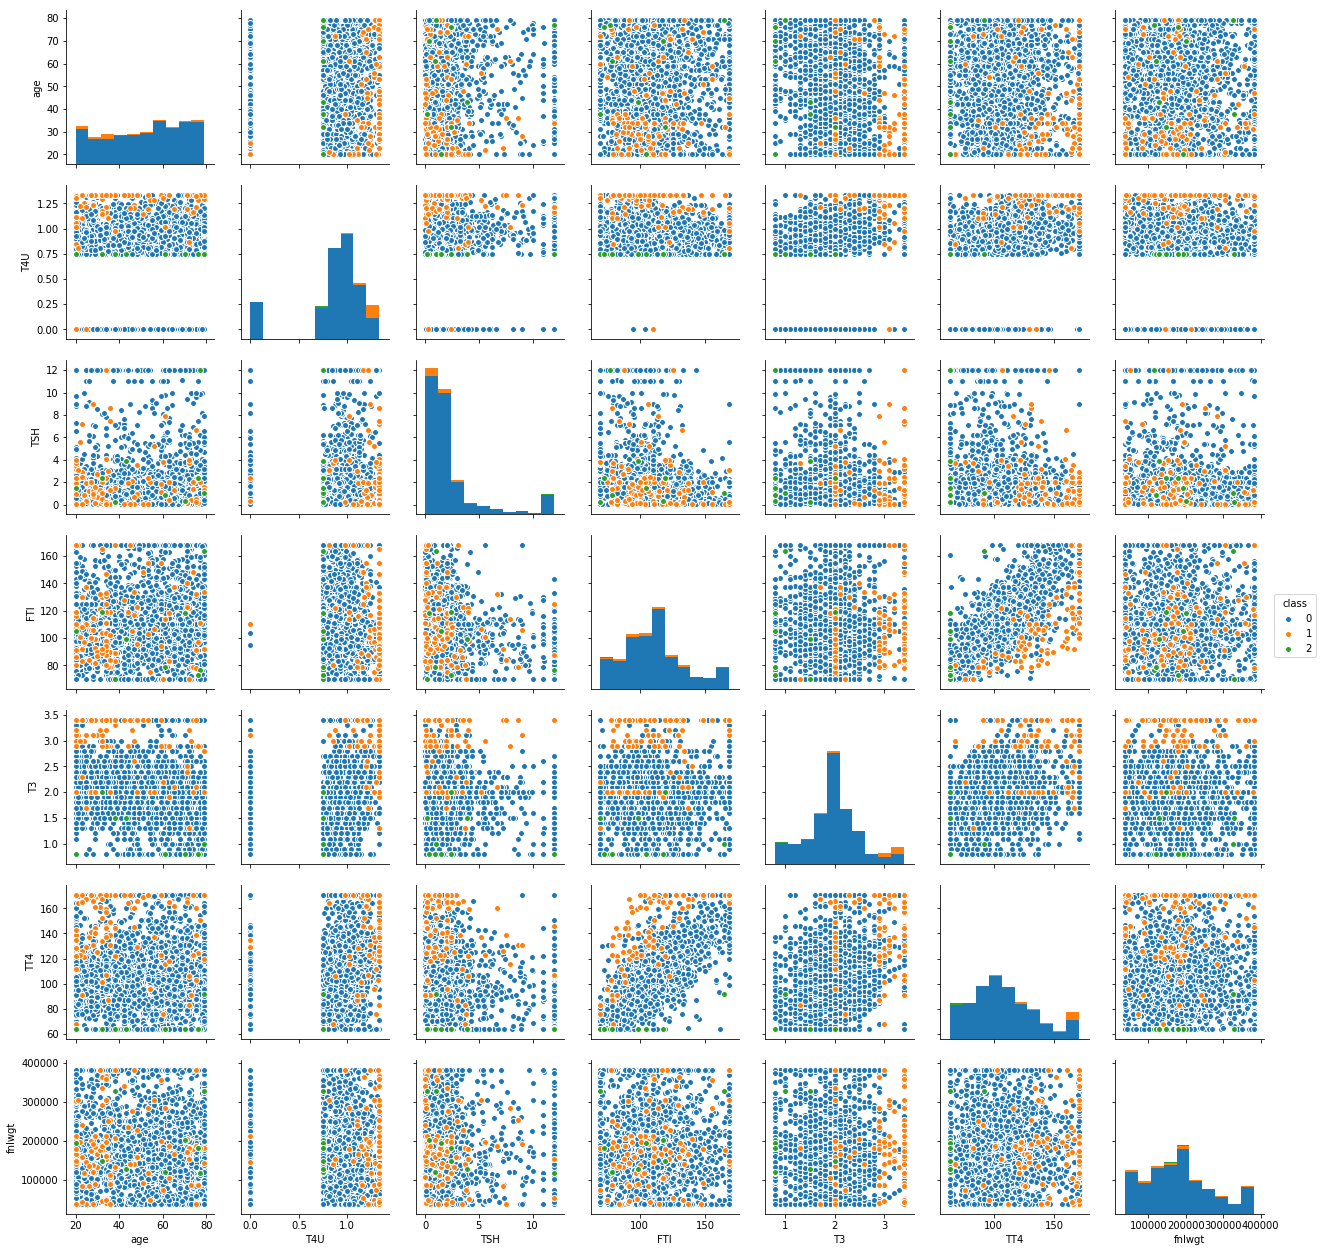

In [110]:
sns.pairplot(merged, hue="class",vars=["age","T4U","TSH","FTI","T3","TT4","fnlwgt"])

Ak je hodnota fnlwgt medzi 10000 a 20000 a T4U je medzi 0.7 a 0.9 tak ma clovek decreased binding protein ak je T4U vacie ako 1.4 ale fnlwght nas neyauma increased

In [107]:
def predict_class_fnlwgt_T4U(df):
    predicted = df["class"].map(lambda x: x)
    for index,row in df.iterrows():
        if(df["fnlwgt"][index] > 10000 and df["fnlwgt"][index] < 20000 and df["T4U"][index] > 0.70 and df["T4U"][index] < 0.90):
            print('afoj')
            predicted[index] = 2
        elif(df["T4U"][index] > 1.4):
            predicted[index] = 1
        else:
            predicted[index] = 0 
    return predicted
                  
predicted =  predict_class_fnlwgt_T4U(merged_valid)
print(classification_report(merged_valid["class"], predicted)) 
print("Správnosť", accuracy_score(merged_valid["class"], predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       942
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00         5

   micro avg       0.97      0.97      0.97       972
   macro avg       0.32      0.33      0.33       972
weighted avg       0.94      0.97      0.95       972

Správnosť 0.9691358024691358
